# Advanced: solver_times

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

Let's get started with some basic imports

In [2]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt

And then we'll build a synthetic "dataset" and initialize a new bundle with those data

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', times=phoebe.linspace(0,5,1001))
b.add_compute('ellc', compute='ellc01')
b.set_value_all('ld_mode', 'lookup')
b.run_compute('ellc01')

times = b.get_value('times@model')
fluxes = b.get_value('fluxes@model')
sigmas = np.ones_like(times) * 0.01

b = phoebe.default_binary()
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101),
              times=times, fluxes=fluxes, sigmas=sigmas)
b.add_compute('ellc', compute='ellc01')
b.set_value_all('ld_mode', 'lookup')
b.add_solver('optimizer.nelder_mead', compute='ellc01', fit_parameters=['teff'], solver='nm_solver')

100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


<ParameterSet: 12 parameters | qualifiers: adaptive, fit_parameters, xatol, maxiter, compute, fatol, initial_values, priors, priors_combine, comments, maxfev, expose_lnprobabilities>

## solver_times parameter and options

In [4]:
print(b.filter(qualifier='solver_times'))

ParameterSet: 1 parameters
        solver_times@lc01@dataset: auto


In [5]:
print(b.get_parameter(qualifier='solver_times', dataset='lc01').choices)

['auto', 'compute_times', 'times']


The logic for solver times is generally only used internally within [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (for optimizers and samplers which require a forward-model to be computed).  However, it is useful (in order to diagnose any issues, for example) to be able to see how the combination of `solver_times`, `times`, `compute_times`/`compute_phases`, `mask_enabled`, and `mask_phases` will be interpretted within PHOEBE during [b.run_solver](../api/phoebe.bundle.Bundle.run_solver.md).

See also:
* [Advanced: mask_phases](./mask_phases.ipynb)
* [Advanced: Compute Times & Phases](./compute_times_phases.ipynb)

To access the underlying times that would be used, we can call [b.parse_solver_times](../api/phoebe.frontend.bundle.Bundle.parse_solver_times.md).  Let's first look at the docstring (also available from the link above):

In [6]:
help(b.parse_solver_times)

Help on method parse_solver_times in module phoebe.frontend.bundle:

parse_solver_times(return_as_dict=True, set_compute_times=False) method of phoebe.frontend.bundle.Bundle instance
    Parse what times will be used within <phoebe.frontend.bundle.Bundle.run_solver>
    (for any optimizer or sampler that requires a forward-model)
    or when passing `solver` to <phoebe.frontend.bundle.Bundle.run_compute>,
    based on the value of `solver_times`, `times`, `compute_times`, `mask_enabled`,
    `mask_phases`, and <phoebe.parameters.HierarchyParameter.is_time_dependent>.
    
    Note: this is not necessary to call manually as it will be called and
    handled automatically within <phoebe.frontend.bundle.Bundle.run_solver>
    or <phoebe.frontend.bundle.Bundle.run_compute>.  This method only exposes
    the same logic to diagnose the influence of these options on the computed
    times.
    
    Overview of logic:
    * if `solver_times='times' but not `mask_enabled`: returns the dataset-t

Additionally, we can pass `solver` to [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) to have the forward-model computed as it would be within the solver itself (this just calls `run_compute` with the compute option referenced by the solver and with the parsed `solver_times`).

Below we'll go through each of the scenarios listed above and demonstrate how that logic changes the times at which the forward model will be computed within [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (with the cost-function interpolating between the resulting forward-model and the observations as necessary).

The messages regarding the internal choice of logic for `solver_times` will be exposed at the 'info' level of the logger.  We'll leave that off here to avoid the noise of the logger messages from `run_compute` calls, but you can uncomment the following line to see those messages.

In [7]:
#logger = phoebe.logger('info')

## solver_times = 'times'

### without phase_mask enabled

In [8]:
b.set_value('solver_times', 'times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

{'lc01': array([0.   , 0.005, 0.01 , ..., 4.99 , 4.995, 5.   ])}


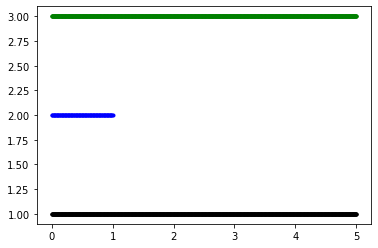

In [9]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
print(solver_times)
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


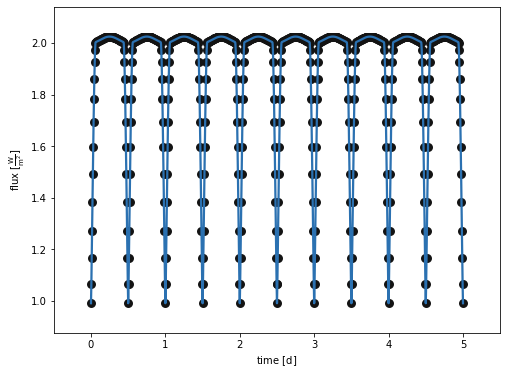

In [10]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

### with phase_mask enabled

In [11]:
b.set_value('solver_times', 'times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', True)
b.set_value('mask_phases', [(-0.1, 0.1), (0.45,0.55)])
b.set_value('dperdt', 0.0)

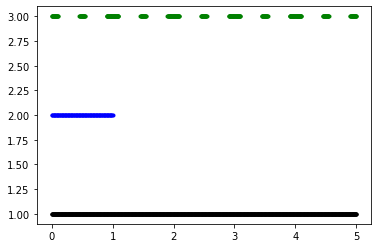

In [12]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


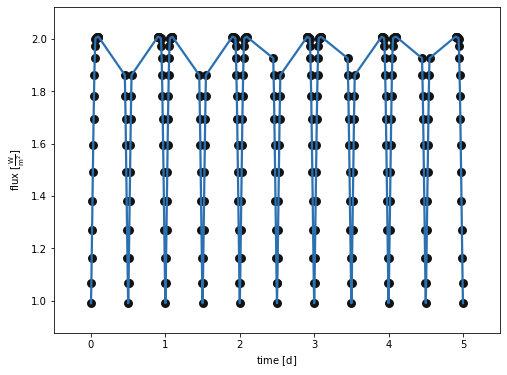

In [13]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

## solver_times = 'compute_times'

### without phase_mask enabled

In [14]:
b.set_value('solver_times', 'compute_times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

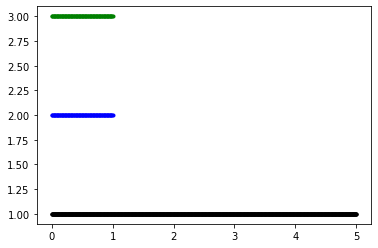

In [15]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 150.17it/s]


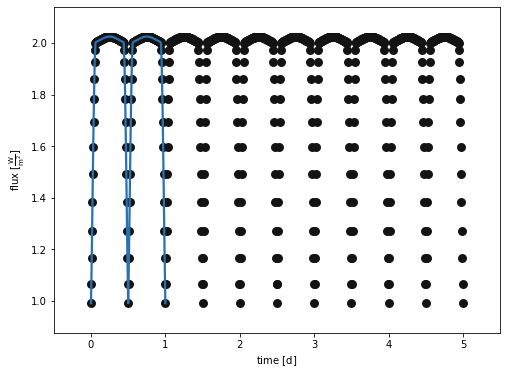

In [16]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

### with phase_mask enabled and time-independent hierarchy

In [17]:
b.set_value('solver_times', 'compute_times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', True)
b.set_value('mask_phases', [(-0.1, 0.1), (0.45,0.55)])
b.set_value('dperdt', 0.0)

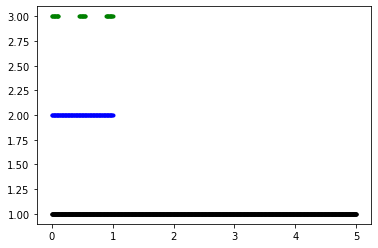

In [18]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 243.27it/s]


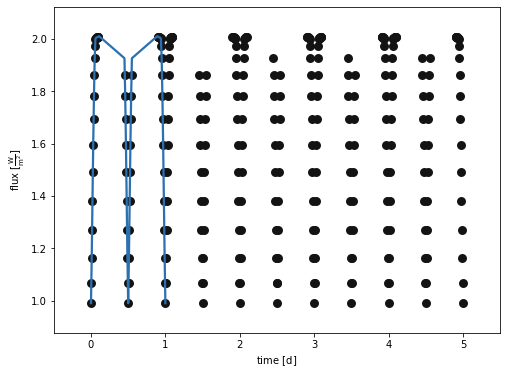

In [19]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

### with phase_mask enabled and time-dependent hierarchy

In [20]:
b.set_value('solver_times', 'compute_times')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', True)
b.set_value('mask_phases', [(-0.1, 0.1), (0.45,0.55)])
b.set_value('dperdt', 0.1)

print(b.hierarchy.is_time_dependent())

True


In the case where we have a time-dependent system [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) will fail with an error from [b.run_checks_solver](../api/phoebe.frontend.bundle.Bundle.run_checks_solver.md) if `compute_times` does not fully encompass the dataset times.

In [21]:
print(b.run_checks_solver())

Run Checks Report: FAIL
ERROR: 'compute_times@lc01' must cover full range of 'times@lc01', for time-dependent systems with solver_times@lc01='compute_times'. Consider flipping the 'compute_phases' constraint and providing 'compute_times' instead. (5 affected parameters, affecting run_solver)


This will always be the case when providing `compute_phases` when the dataset times cover more than a single cycle.  Here we'll follow the advice from the error and provide `compute_times` instead.

In [22]:
b.flip_constraint('compute_times', solve_for='compute_phases')
b.set_value('compute_times', phoebe.linspace(0,5,501))

In [23]:
print(b.run_checks_solver())

Run Checks Report: PASS



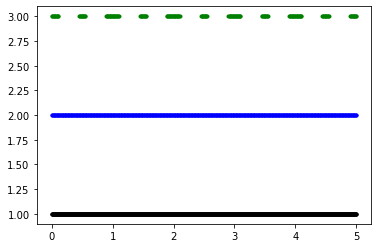

In [24]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 80.08it/s]


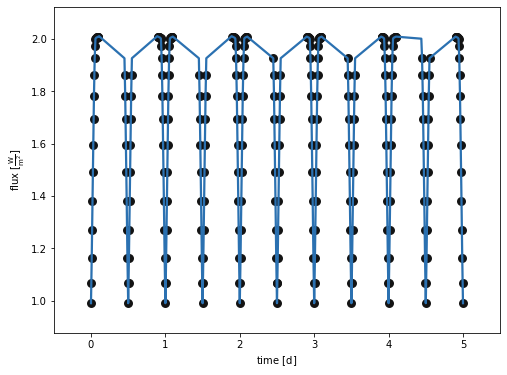

In [25]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

Now we'll just flip the constraint back for the remaining examples

In [26]:
_ = b.flip_constraint('compute_phases', solve_for='compute_times')

## solver_times = 'auto'

`solver_times='auto'` determines the times array under both conditions (`solver_times='times'` and `solver_times='compute_times'`) and ultimately chooses whichever of the two is shorter.

To see this, we'll stick with the no-mask, time-independent case and change the length of `compute_phases` to show the switch to the shorter of the available options.

### compute_times shorter

In [27]:
b.set_value('solver_times', 'auto')
b.set_value('compute_phases', phoebe.linspace(0,1,101))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

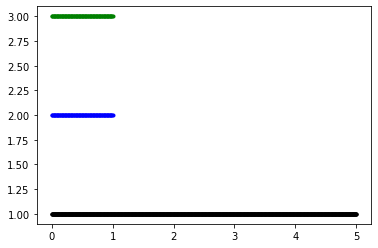

In [28]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 150.13it/s]


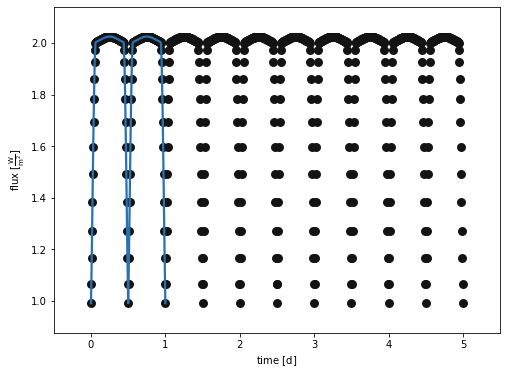

In [29]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)

### times shorter

In [30]:
b.set_value('solver_times', 'auto')
b.set_value('compute_phases', phoebe.linspace(0,1,2001))
b.set_value('mask_enabled', False)
b.set_value('dperdt', 0.0)

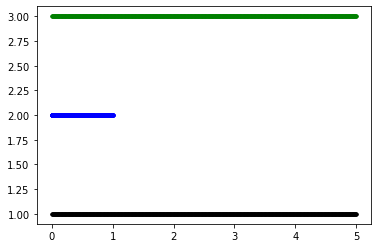

In [31]:
dataset_times = b.get_value('times', context='dataset')
_ = plt.plot(times, np.ones_like(times)*1, 'k.')

compute_times = b.get_value('compute_times', context='dataset')
_ = plt.plot(compute_times, np.ones_like(compute_times)*2, 'b.')

solver_times = b.parse_solver_times()
_ = plt.plot(solver_times['lc01'], np.ones_like(solver_times['lc01'])*3, 'g.')

100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


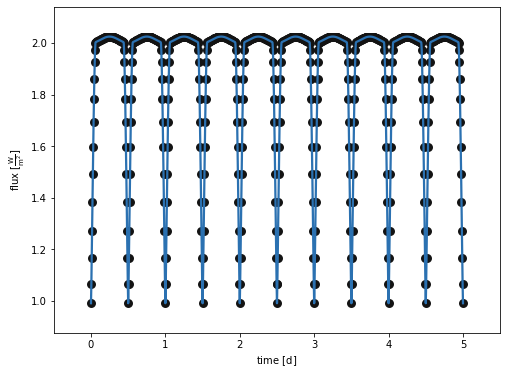

In [32]:
b.run_compute(solver='nm_solver')
_ = b.plot(show=True)